# 네이버 웹툰

2022.03.30 ver.

수집 웹툰 URL: https://comic.naver.com/webtoon/list?titleId=784255&weekday=wed

## 기본 환경 세팅

In [1]:
!pip install selenium

In [2]:
import pandas as pd
import numpy as np
import time
from selenium import webdriver

jupyter notebook은 chromedriver 설치 경로를 지정해주지만 colab은 하위와 같이 설치하고,

colab 자체가 headless mode라서 창을 띄우는게 불가능하므로 jupyter notebook처럼 수집이 잘 되고 있는지 실시간으로는 확인이 불가능합니다.

In [ ]:
!apt-get update # ubuntu 업데이트
!apt install chromium-chromedriver

In [4]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # 내부 창을 띄울 수 없으므로 설정
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


In [5]:
# 수집하고자 하는 웹툰 주소
driver.get("https://comic.naver.com/webtoon/list?titleId=784255&weekday=wed")

## 웹툰 베스트댓글 크롤러

In [6]:
data = pd.DataFrame(data=[], columns=['회차','날짜','이름','아이디','댓글'])

In [7]:
def collector(driver, data, k):
    driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    # 수집하고자 하는 웹툰 회차의 마지막 페이지 URL을 입력
    # https://comic.naver.com/webtoon/detail?titleId=784255&no=43&weekday=wed
    url = 'https://comic.naver.com/webtoon/detail?titleId=784255&no='+str(k)
    driver.get(url)
    time.sleep(2)
    
    # 해당 프레임으로 이동
    driver.switch_to.frame('commentIframe')
    
    # 경로 지정
    num = k
    names = driver.find_elements_by_css_selector('.u_cbox_nick')
    dates = driver.find_elements_by_css_selector('.u_cbox_date')
    user_ids = driver.find_elements_by_css_selector('.u_cbox_id')
    reviews = driver.find_elements_by_css_selector('.u_cbox_contents')

    for i in range(len(names)):
        temp = []
        
        # 요소를 추가하는 코드
        temp.append(num)
        temp.append(dates[i].text)
        temp.append(names[i].text)
        temp.append(user_ids[i].text)
        temp.append(reviews[i].text)
        
        temp = pd.DataFrame(data=[temp], columns=data.columns)
        
        # 여러 범위 또는 문자열의 텍스트를 결합
        data = pd.concat([data,temp])
        
    driver.close()
    print(str(num) + '화 베스트 댓글 수집 끝')
    
    return data

마지막 회차의 주소를 통해, 43회차까지 있음을 알 수 있습니다.

```
https://comic.naver.com/webtoon/detail?titleId=784255&no=43&weekday=wed
```


In [ ]:
for k in range(1,44): # 1화~43화까지 수집 / (1, 회차+1)
  data = collector(driver, data, k)

In [23]:
data.head(3) 
# 베스트 댓글은 1회당 15개가 있음
# 저작권 관계로 일부만 노출
# data

,회차,날짜,이름,아이디,댓글
0,1,2021-11-02 13:10,아이스 핫초코,(sseo****),한국인 특)안부인사 : 밥 잘 먹고 다니냐?잘못했을 때 : 국물도 없을줄 알아
0,1,2021-11-02 13:34,여름이좋아,(skyi****),이렇게 차기작으로 오시면 계속 좋아해줄것 같죠? 크나큰 오예입니다
0,1,2021-11-02 14:47,인간,(qkrw****),어... 기쁘긴 한데 너무 빨리 오셔서 당황스러운데요...마치 애인이 먼 곳으로 발...


In [10]:
# 파일로 저장1: 엑셀 데이터프레임 구조 (워드클라우드 만들기 때문에 이 부분은 skip)
# data.to_excel('네이버웹툰_먹는인생_베스트댓글.xlsx', sheet_name='sheet1')

# 파일로 저장2: 워드클라우드를 위한 txt 형태로의 저장
best_review = data['댓글']
best_review
best_review.to_csv('먹는인생_베스트댓글.txt', index = False) # index = False 인덱스 없애기

## 웹툰 베스트 댓글 워드클라우드

In [11]:
!pip install konlpy

In [12]:
import os
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [13]:
os.getcwd()

'/content'

In [14]:
with open('먹는인생_베스트댓글.txt', 'r', encoding='utf-8') as f:
    text = f.read()

okt = Okt()
nouns = okt.nouns(text) # 명사만 추출
words = [n for n in nouns if len(n) > 1] # 단어의 길이가 1개인 것은 제외

In [ ]:
# 한글 폰트 설치
! apt-get install fonts-nanum*

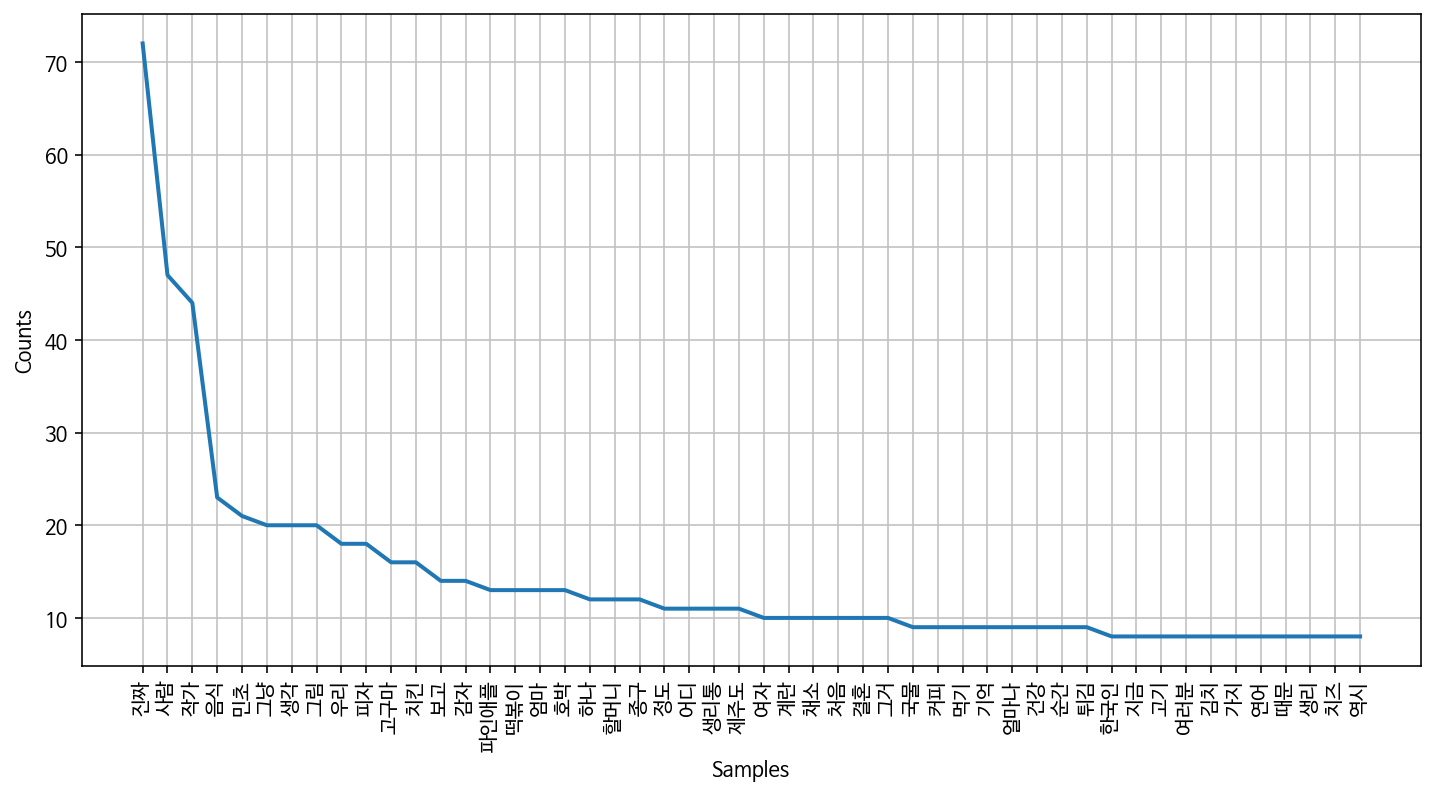

In [16]:
import nltk
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

plt.figure(figsize=(12,6))
words = nltk.Text(words, name='단어 빈도수')
words.plot(50) # 50개만
plt.show()

In [17]:
# 단어 빈도표를 보고 일부 단어 불용어 처리
stopword = ['진짜','그냥', '정도', '어디', '처음', '그거', '얼마나']
text = [i for i in words if i not in stopword]
text_cnt = Counter(text)

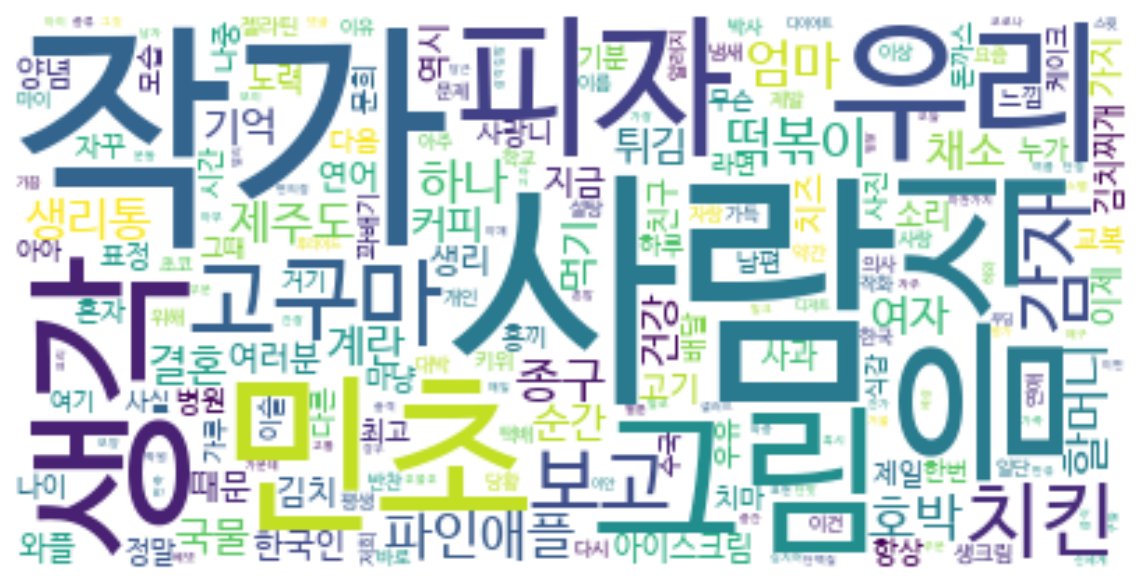

In [20]:
# colormap 글씨색 설정 가능, img_mask, mask 모양 설정
# img_mask = np.array(Image.open("heart.png"))

wordcloud = WordCloud(font_path = fontpath, 
                      background_color='white',
                      # colormap = "Accent_r", 
                      # mask = img_mask, 
                      random_state = 20, 
                      max_words = 200).generate_from_frequencies(text_cnt)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")        
plt.axis("off")

plt.savefig("result_weebtoon.png")
plt.show()